In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [23]:
df_2018 = spark.read.csv(f"C:/Users/gyalm/OneDrive/Desktop/churn_prediction/churn_prediction/data/week2_data_for_student_lab.csv.gz", inferSchema=True, header=True)
df_2018.show(10)
df_2018.createOrReplaceTempView("df_2018_view")

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [4]:
spark.sql('''SELECT * FROM df_2018_view LIMIT 5''').show()

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [5]:
spark.sql('''
WITH customer_base AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
),
customer_base_joined_with_past_3_months_txn AS (
    SELECT 
        a.member_id,
        b.quantity,
        b.transaction_date
    FROM customer_base AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
),
customer_base_with_aggregated_total_txns_per_month AS (
    SELECT 
        member_id,
        SUM(
            CASE 
                WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' 
                THEN quantity 
                ELSE 0 
            END
        ) AS sum_quantity,
        '2018-06-01' AS partition_month
    FROM customer_base_joined_with_past_3_months_txn
    GROUP BY member_id
),
customers_with_target_definition AS (
    SELECT 
        *,
        CASE 
            WHEN sum_quantity = 0 THEN 1 
            ELSE 0 
        END AS target
    FROM customer_base_with_aggregated_total_txns_per_month
),
count_customers_with_target_definition AS (
    SELECT 
        target,
        COUNT(member_id) AS cnt_member_id,
        COUNT(DISTINCT member_id) AS cntd_member_id
    FROM customers_with_target_definition
    GROUP BY target
)

SELECT * 
FROM count_customers_with_target_definition
''').show()


+------+-------------+--------------+
|target|cnt_member_id|cntd_member_id|
+------+-------------+--------------+
|     1|        15873|         15873|
|     0|        34794|         34794|
+------+-------------+--------------+



In [6]:
# Show first 5 rows of features for modeling
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,a.partition_date
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features LIMIT 5
  --count_customers_with_target_definition
''').show()

+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+
|           member_id|target|partition_date|sum_amount_accessories|sum_amount_appliances|sum_amount_cleaners|sum_amount_clothes|sum_amount_food|sum_amount_frozen_food|sum_amount_gadgets|sum_amount_hardware|sum_amount_pet|sum_amount_shoes|
+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+
|001787f6-cfdb-11e...|     0|    2018-06-01|                     0|                    0|                  0|                 0|              0|                     0|                 0|                  0|             0|               0|
|010ee11a-cfdb-11e...|     0|    2018-06-01|

In [7]:
# Create modeling ABT (analytics base table)
df_mabt = spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-07-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
  ,a.partition_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features
  --LIMIT 5
  --count_customers_with_target_definition
''')
df_mabt.createOrReplaceTempView("df_mabt_view")

In [8]:
# Save modeling ABT as pandas
pdf_mabt = df_mabt.toPandas()
pdf_mabt.head()

,member_id,target,sum_amount_accessories,sum_amount_appliances,sum_amount_cleaners,sum_amount_clothes,sum_amount_food,sum_amount_frozen_food,sum_amount_gadgets,sum_amount_hardware,sum_amount_pet,sum_amount_shoes,partition_date
0,00000864-cfdb-11eb-9633-d8f2ca37414f,0,0,0,0,0,0,0,0,0,0,0,2018-07-01
1,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,3600,0,0,0,0,9400,3200,0,15000,9900,2018-07-01
2,0000086b-cfdb-11eb-81cf-d8f2ca37414f,0,0,0,0,0,0,0,0,0,0,0,2018-07-01
3,0000087b-cfdb-11eb-ab7f-d8f2ca37414f,0,5400,0,9100,0,0,0,0,0,5300,0,2018-07-01
4,00000880-cfdb-11eb-8d6f-d8f2ca37414f,0,0,0,0,0,0,0,0,0,10600,4600,2018-07-01


In [9]:
# Check column names in data
pdf_mabt.columns

Index(['member_id', 'target', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'partition_date'],
      dtype='object')

In [10]:
# Check summary statistics
pdf_mabt[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_amount_accessories,50667.0,433.001757,1771.769079,0.0,0.0,0.0,0.0,27800.0
sum_amount_appliances,50667.0,391.529003,1646.328998,0.0,0.0,0.0,0.0,23900.0
sum_amount_cleaners,50667.0,2537.906330,5845.770163,0.0,0.0,0.0,0.0,71000.0
sum_amount_clothes,50667.0,442.706298,1805.479190,0.0,0.0,0.0,0.0,23000.0
sum_amount_food,50667.0,401.170387,1707.918547,0.0,0.0,0.0,0.0,22400.0
sum_amount_frozen_food,50667.0,448.487181,1793.683305,0.0,0.0,0.0,0.0,34600.0
sum_amount_gadgets,50667.0,418.440010,1738.975410,0.0,0.0,0.0,0.0,27500.0
sum_amount_hardware,50667.0,410.865060,1717.823263,0.0,0.0,0.0,0.0,24000.0
sum_amount_pet,50667.0,2352.296366,4988.124531,0.0,0.0,0.0,3300.0,60400.0
sum_amount_shoes,50667.0,391.580319,1663.879980,0.0,0.0,0.0,0.0,26400.0


In [11]:
# Check summary statistics per target definition
pdf_mabt.groupby(['target'])[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes']].describe().T

target                                   0             1
sum_amount_accessories count  34794.000000  15873.000000
                       mean     433.557510    431.783532
                       std     1781.755727   1749.733836
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    27800.000000  21100.000000
sum_amount_appliances  count  34794.000000  15873.000000
                       mean     395.686038    382.416682
                       std     1658.075562   1620.296825
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    23900.000000  22500.000000
sum_amount_cleaners    count  34794.000000  15873.000000
                       mean    2526.153935   2563.667864
                       std     5821.540145   5898.637125
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    71000.000000  63900.000000
sum_amount_clothes     count  34794.000000  15873.000000
                       mean     438.265218    452.441252
                       std     1798.786813   1820.081957
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    23000.000000  17700.000000
sum_amount_food        count  34794.000000  15873.000000
                       mean     392.846468    419.416619
                       std     1689.032908   1748.518162
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    22400.000000  20100.000000
sum_amount_frozen_food count  34794.000000  15873.000000
                       mean     448.652066    448.125748
                       std     1795.244213   1790.313436
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    24800.000000  34600.000000
sum_amount_gadgets     count  34794.000000  15873.000000
                       mean     416.798873    422.037422
                       std     1740.617205   1735.420462
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    27500.000000  18400.000000
sum_amount_hardware    count  34794.000000  15873.000000
                       mean     412.148646    408.051408
                       std     1722.759832   1707.002947
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    24000.000000  21700.000000
sum_amount_pet         count  34794.000000  15873.000000
                       mean    2364.591596   2325.344925
                       std     5019.944634   4917.703229
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
          

In [13]:
# Copy data for modeling
data = pdf_mabt[['target', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       ]].copy()

In [14]:
# Separate target variable and features
y = data['target']
X = data.drop(['target'], axis=1)

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Model
estimator = LogisticRegression()

# Create transformers for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        #('cat_onehot', OneHotEncoder(handle_unknown='ignore'), [])
        #,
         ('num_standard', StandardScaler(), ['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes'])
        #,('num_minmax', MinMaxScaler(), [])
    ],
    remainder='passthrough',
)

# Create a logistic regression model using a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
    ,('estimator', estimator)
])

# Fit training data into model pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  StandardScaler(),
                                                  ['sum_amount_accessories',
                                                   'sum_amount_appliances',
                                                   'sum_amount_cleaners',
                                                   'sum_amount_clothes',
                                                   'sum_amount_food',
                                                   'sum_amount_frozen_food',
                                                   'sum_amount_gadgets',
                                                   'sum_amount_hardware',
                                                   'sum_amount_pet',
                                                   'sum_amount_shoes'])])),
                ('estimator', LogisticRegression())])

Accuracy: 0.69
Precision: 0.00
Recall: 0.00

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     27863
           1       0.00      0.00      0.00     12670

    accuracy                           0.69     40533
   macro avg       0.34      0.50      0.41     40533
weighted avg       0.47      0.69      0.56     40533

[[27863     0]
 [12670     0]]


c:\Python Software\Python3_12_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python Software\Python3_12_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python Software\Python3_12_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python Software\Python3_

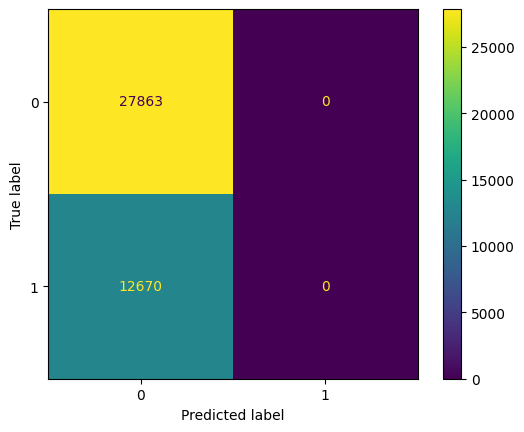

In [17]:
# Make predictions on the train set
y_pred_train = pipeline.predict(X_train)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train)

print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Recall: {recall_train:.2f}")
print(f"\nConfusion Matrix:")
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train))
print(cm_train)

cmd_train = ConfusionMatrixDisplay(cm_train)
cmd_train.plot()

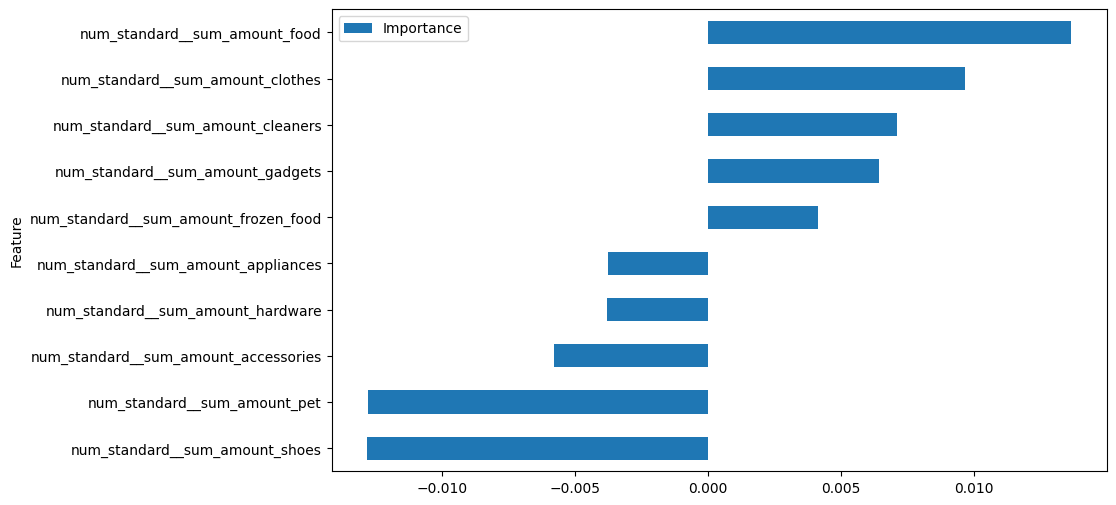

Intercept: -0.7882015726598848


In [18]:
#### Get coefficients & intercept

coefficients = pipeline.named_steps.estimator.coef_[0]
feature_names = pipeline.named_steps.preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

intercept = pipeline.named_steps.estimator.intercept_[0]
print(f'Intercept: {intercept}')

In [28]:
# Create modeling ABT (analytics base table)
df_mabt = spark.sql('''
WITH customer_base AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_data AS (
    SELECT
        a.member_id,
        b.age,
        b.branch_name,
        b.region,
        b.age
    FROM customer_base AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
)
,customer_purchases AS (
    SELECT
        a.member_id,
        c.branch_name,
        c.region,
        c.age,
        b.category_name,
        SUM(b.amount) AS total_spending
    FROM customer_base AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-01-01' AND '2018-06-30'
    LEFT JOIN customer_data AS c
    ON a.member_id = c.member_id
    GROUP BY a.member_id, c.branch_name, c.region, c.age, b.category_name
)
,ranked_purchases AS (
    SELECT
        branch_name,
        region,
        age,
        category_name,
        total_spending,
        RANK() OVER (PARTITION BY branch_name ORDER BY total_spending DESC) AS purchase_rank
    FROM customer_purchases
)
SELECT 
    branch_name,
    region,
    age,
    category_name AS top_category,
    total_spending
FROM ranked_purchases
WHERE purchase_rank = 1
ORDER BY branch_name, region, age
''')
df_mabt.createOrReplaceTempView("df_mabt_view")

In [29]:
# Save modeling ABT as pandas
pdf_mabt = df_mabt.toPandas()
pdf_mabt.head()

,branch_name,region,age,top_category,total_spending
0,A_Store,1,40-45,CLEANERS,653400
1,B_Store,1,55-60,CLEANERS,418000
2,C_Store,1,45-50,CLEANERS,561000
3,D_Store,2,35-40,CLEANERS,545000
4,E_Store,3,45-50,CLEANERS,579600


In [57]:
# Create modeling ABT (analytics base table)
df_mabt = spark.sql('''
WITH
customer_base AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
    SELECT
        a.member_id,
        b.quantity,
        b.transaction_date
    FROM customer_base AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
    SELECT
        member_id,
        SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity,
        '2018-07-01' AS partition_date
    FROM customer_base_joined_with_past_3_months_txn
    GROUP BY member_id
)
,customers_with_target_definition AS (
    SELECT
        *,
        CASE WHEN sum_quantity = 0 THEN 1 ELSE 0 END AS target
    FROM customer_base_with_aggregated_total_txns_per_month
)
,customers_joined_with_features AS (
    SELECT
        a.member_id,
        b.branch_name,
        b.quantity,
        b.amount,
        b.category_name,
        b.transaction_date
    FROM customers_with_target_definition AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_branch AS (
    SELECT
        member_id,
        SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND branch_name = 'A_Store' THEN amount ELSE 0 END) AS sum_amount_branch_a,
        SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND branch_name = 'B_Store' THEN amount ELSE 0 END) AS sum_amount_branch_b,
        SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND branch_name = 'C_Store' THEN amount ELSE 0 END) AS sum_amount_branch_c,
        SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND branch_name = 'D_Store' THEN amount ELSE 0 END) AS sum_amount_branch_d,
        SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND branch_name = 'E_Store' THEN amount ELSE 0 END) AS sum_amount_branch_e,
        SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND branch_name = 'F_Store' THEN amount ELSE 0 END) AS sum_amount_branch_f,
        SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND branch_name = 'I_Store' THEN amount ELSE 0 END) AS sum_amount_branch_i,
        SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND branch_name = 'J_Store' THEN amount ELSE 0 END) AS sum_amount_branch_j
    FROM customers_joined_with_features
    GROUP BY member_id
)
,top_category_per_member AS (
    SELECT 
        member_id,
        category_name AS top_category,
        RANK() OVER (PARTITION BY member_id ORDER BY SUM(amount) DESC) AS rank
    FROM customers_joined_with_features
    GROUP BY member_id, category_name
)
,top_category_filtered AS (
    SELECT member_id, top_category
    FROM top_category_per_member
    WHERE rank = 1
)
,customers_with_target_joined_with_features AS (
    SELECT
        a.member_id,
        a.target,
        c.top_category,
        b.sum_amount_branch_a,
        b.sum_amount_branch_b,
        b.sum_amount_branch_c,
        b.sum_amount_branch_d,
        b.sum_amount_branch_e,
        b.sum_amount_branch_f,
        b.sum_amount_branch_i,
        b.sum_amount_branch_j,
        a.partition_date
    FROM customers_with_target_definition AS a
    LEFT JOIN aggregated_branch AS b ON a.member_id = b.member_id
    LEFT JOIN top_category_filtered AS c ON a.member_id = c.member_id
)

SELECT *
FROM customers_with_target_joined_with_features
''')
df_mabt.createOrReplaceTempView("df_mabt_view")


In [58]:
# Save modeling ABT as pandas
pdf_mabt = df_mabt.toPandas()
pdf_mabt.head()

,member_id,target,top_category,sum_amount_branch_a,sum_amount_branch_b,sum_amount_branch_c,sum_amount_branch_d,sum_amount_branch_e,sum_amount_branch_f,sum_amount_branch_i,sum_amount_branch_j,partition_date
0,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,PET,0,0,0,0,0,9900,4400,26800,2018-07-01
1,0000086b-cfdb-11eb-81cf-d8f2ca37414f,0,None,0,0,0,0,0,0,0,0,2018-07-01
2,00000886-cfdb-11eb-96e8-d8f2ca37414f,0,None,0,0,0,0,0,0,0,0,2018-07-01
3,00000889-cfdb-11eb-895d-d8f2ca37414f,0,None,0,0,0,0,0,0,0,0,2018-07-01
4,00000895-cfdb-11eb-b56c-d8f2ca37414f,0,SHOES,0,0,0,0,0,0,0,5000,2018-07-01


In [59]:
# Check column names in data
pdf_mabt.columns

Index(['member_id', 'target', 'top_category', 'sum_amount_branch_a',
       'sum_amount_branch_b', 'sum_amount_branch_c', 'sum_amount_branch_d',
       'sum_amount_branch_e', 'sum_amount_branch_f', 'sum_amount_branch_i',
       'sum_amount_branch_j', 'partition_date'],
      dtype='object')

In [62]:
# Check summary statistics
pdf_mabt[['member_id', 'top_category', 'sum_amount_branch_a',
       'sum_amount_branch_b', 'sum_amount_branch_c', 'sum_amount_branch_d',
       'sum_amount_branch_e', 'sum_amount_branch_f', 'sum_amount_branch_i',
       'sum_amount_branch_j', 'partition_date']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_amount_branch_a,50799.0,853.707750,3529.244165,0.0,0.0,0.0,0.0,53200.0
sum_amount_branch_b,50799.0,801.629953,3380.959908,0.0,0.0,0.0,0.0,58700.0
sum_amount_branch_c,50799.0,860.188193,3522.229510,0.0,0.0,0.0,0.0,46800.0
sum_amount_branch_d,50799.0,808.411583,3422.033391,0.0,0.0,0.0,0.0,52100.0
sum_amount_branch_e,50799.0,798.206658,3341.416365,0.0,0.0,0.0,0.0,56700.0
sum_amount_branch_f,50799.0,840.105120,3436.019477,0.0,0.0,0.0,0.0,52300.0
sum_amount_branch_i,50799.0,813.254198,3383.506376,0.0,0.0,0.0,0.0,58700.0
sum_amount_branch_j,50799.0,829.595071,3427.790220,0.0,0.0,0.0,0.0,59700.0


In [63]:
# Copy data for modeling
data = pdf_mabt[['member_id', 'target', 'top_category', 'sum_amount_branch_a',
       'sum_amount_branch_b', 'sum_amount_branch_c', 'sum_amount_branch_d',
       'sum_amount_branch_e', 'sum_amount_branch_f', 'sum_amount_branch_i',
       'sum_amount_branch_j', 'partition_date',
       ]].copy()

In [64]:
# Separate target variable and features
y = data['target']
X = data.drop(['target'], axis=1)

In [65]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Model
estimator = LogisticRegression()

# Create transformers for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        #('cat_onehot', OneHotEncoder(handle_unknown='ignore'), [])
        #,
        ('num_standard', StandardScaler(), ['sum_amount_branch_a',
       'sum_amount_branch_b', 'sum_amount_branch_c', 'sum_amount_branch_d',
       'sum_amount_branch_e', 'sum_amount_branch_f', 'sum_amount_branch_i',
       'sum_amount_branch_j',
       ])
        #,('num_minmax', MinMaxScaler(), [])
    ],
    remainder='passthrough',
)

# Create a logistic regression model using a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
    ,('estimator', estimator)
])

In [71]:
# Fit training data into model pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the train set
y_pred_train = pipeline.predict(X_train)

ValueError: could not convert string to float: '007d9dad-cfdb-11eb-9783-d8f2ca37414f'